<a href="https://colab.research.google.com/github/amanjain487/tsai-eva6/blob/main/Assignments/S9/Resnets_and_Higher_Receptive_Fields.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session 9 - Resnets_and_Higher_Receptive_Fields¶


### Clone Github Repo


In [1]:
%rm -rf 'CIFAR_10'
!git clone https://github.com/amanjain487/CIFAR_10

Cloning into 'CIFAR_10'...
remote: Enumerating objects: 279, done.
remote: Counting objects: 100% (279/279), done.
remote: Compressing objects: 100% (267/267), done.
remote: Total 279 (delta 137), reused 15 (delta 6), pack-reused 0
Receiving objects: 100% (279/279), 64.29 KiB | 2.79 MiB/s, done.
Resolving deltas: 100% (137/137), done.


### Append model path and install Albumentations


In [2]:
import sys
sys.path.append('/CIFAR_10/')
from CIFAR_10 import utils
from CIFAR_10 import main
from CIFAR_10.models.custom_resnet import CustomResNet

!pip install torchsummary
from torchsummary import summary
import torch

In [3]:
!pip install git+https://github.com/albumentations-team/albumentations.git
!pip install torch-lr-finder

from torch_lr_finder import LRFinder

  Cloning https://github.com/albumentations-team/albumentations.git to /tmp/pip-req-build-rklov_2q
  Running command git clone -q https://github.com/albumentations-team/albumentations.git /tmp/pip-req-build-rklov_2q
  Created wheel for albumentations: filename=albumentations-1.0.2-cp37-none-any.whl size=98523 sha256=1ad11d8726dfb4395d96743206e4d24a720173a98fb044befec42c5226822096
  Stored in directory: /tmp/pip-ephem-wheel-cache-p4vz7sd1/wheels/e2/85/3e/2a40fac5cc1f43ced656603bb2fca1327b30ec7de1b1b66517
Successfully built albumentations


In [7]:
device, best_acc, classes, net, criterion, optimizer, scheduler = main.define_model_utilities(CustomResNet(), 
                                                                                              momentum=0.9,
                                                                                              weight_decay = 5e-4,
                                                                                              scheduler = None, 
                                                                                              loss="cross_entropy",
                                                                                              optimizer_func="SGD",
                                                                                              lr=0.1)


In [9]:
summary(net, input_size=(3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3          [-1, 128, 32, 32]          73,728
         MaxPool2d-4          [-1, 128, 16, 16]               0
       BatchNorm2d-5          [-1, 128, 16, 16]             256
            Conv2d-6          [-1, 128, 16, 16]         147,456
            Conv2d-7          [-1, 128, 16, 16]         147,456
       BatchNorm2d-8          [-1, 128, 16, 16]             256
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
      BatchNorm2d-13          [-1, 128, 16, 16]             256
             ReLU-14          [-1, 128,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


### Get transformation function to apply on train dataset


In [10]:
tensor_transforms, numpy_transforms = utils.train_transform(["randomcrop", "horizontal_flip", "cutout"
                                                            , "totensor"
                                                            ,"normalize_mean"
                                                            ])

### Apply transformations and get train and test set


In [11]:
train_set, test_set = utils.load_dataset(tensor_transforms, numpy_transforms)


Files already downloaded and verified
Files already downloaded and verified


### Create Data loaders


In [12]:
train_loader, test_loader = main.dataloaders(train_set, test_set)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [13]:
!python -m pip install -U matplotlib

  Using cached https://files.pythonhosted.org/packages/24/33/5568d443ba438d95d4db635dd69958056f087e57e1026bee56f959d53f9d/matplotlib-3.4.2-cp37-cp37m-manylinux1_x86_64.whl
  Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3


In [14]:
!pip install matplotlib==3.1.3

  Using cached https://files.pythonhosted.org/packages/4c/9b/35ab3469fd1509f7636a344940569ebfd33239673fd2318e80b4700a257c/matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl
  Found existing installation: matplotlib 3.4.2
    Uninstalling matplotlib-3.4.2:
      Successfully uninstalled matplotlib-3.4.2


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 7.18E-01


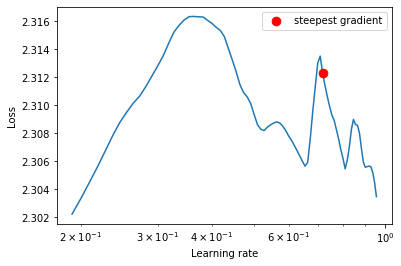

In [15]:
#Find learning rate

from torch_lr_finder import LRFinder

lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, val_loader=test_loader,end_lr=1, num_iter=100, step_mode="linear")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state


In [18]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.428, pct_start=0.208, steps_per_epoch=len(train_loader),
                                                epochs=24,
                                                base_momentum=0.1,
                                                max_momentum = 0.9
                                                )


In [19]:
train_loss, train_acc, test_loss, test_acc = main.start_training(24, net, criterion, optimizer, device, train_loader, test_loader, best_acc, scheduler)


Epoch: 1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train Loss: 1.767 | Train Acc: 69.376% (34688/50000)
Test Loss: 1.774 | Test Acc: 68.480% (6848/10000)

Epoch: 2


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Train Loss: 1.747 | Train Acc: 71.508% (35754/50000)
Test Loss: 1.750 | Test Acc: 71.400% (7140/10000)

Epoch: 3
Train Loss: 1.710 | Train Acc: 75.378% (37689/50000)
Test Loss: 1.716 | Test Acc: 74.700% (7470/10000)

Epoch: 4
Train Loss: 1.692 | Train Acc: 77.178% (38589/50000)
Test Loss: 1.723 | Test Acc: 74.160% (7416/10000)

Epoch: 5
Train Loss: 1.684 | Train Acc: 78.032% (39016/50000)
Test Loss: 1.712 | Test Acc: 75.050% (7505/10000)

Epoch: 6
Train Loss: 1.677 | Train Acc: 78.732% (39366/50000)
Test Loss: 1.708 | Test Acc: 75.520% (7552/10000)

Epoch: 7
Train Loss: 1.672 | Train Acc: 79.214% (39607/50000)
Test Loss: 1.720 | Test Acc: 74.190% (7419/10000)

Epoch: 8
Train Loss: 1.663 | Train Acc: 80.126% (40063/50000)
Test Loss: 1.703 | Test Acc: 75.850% (7585/10000)

Epoch: 9
Train Loss: 1.659 | Train Acc: 80.534% (40267/50000)
Test Loss: 1.696 | Test Acc: 76.900% (7690/10000)

Epoch: 10
Train Loss: 1.654 | Train Acc: 81.154% (40577/50000)
Test Loss: 1.659 | Test Acc: 81.150% (8115

### Retrive correctly predicted images and incorrectly predicted images¶


In [20]:
correct_images, incorrect_images = utils.identify_images(net, criterion, device, test_loader, 20)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Plot graph for losses and accuracies


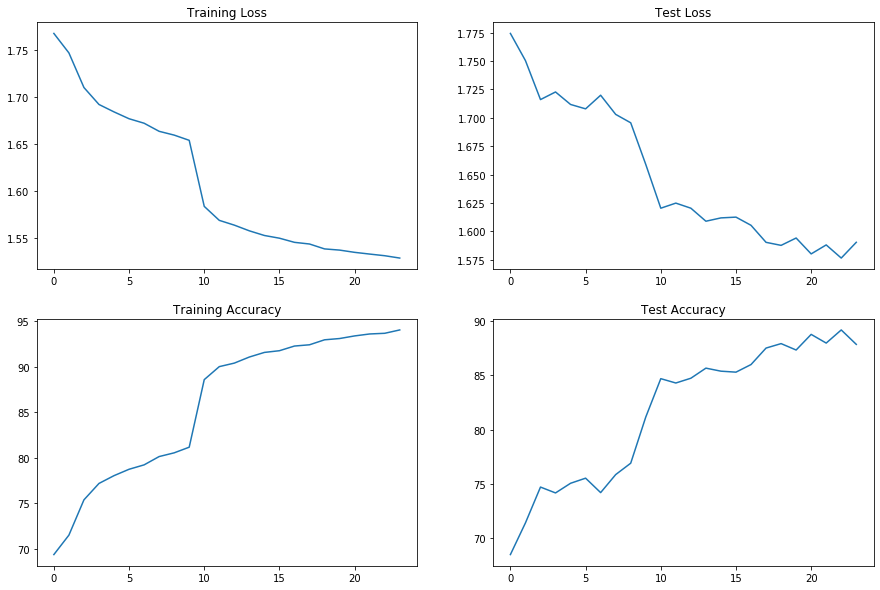

In [21]:
utils.plot_graph(train_loss, train_acc, test_loss, test_acc)


### Plot Correctly predicted Images


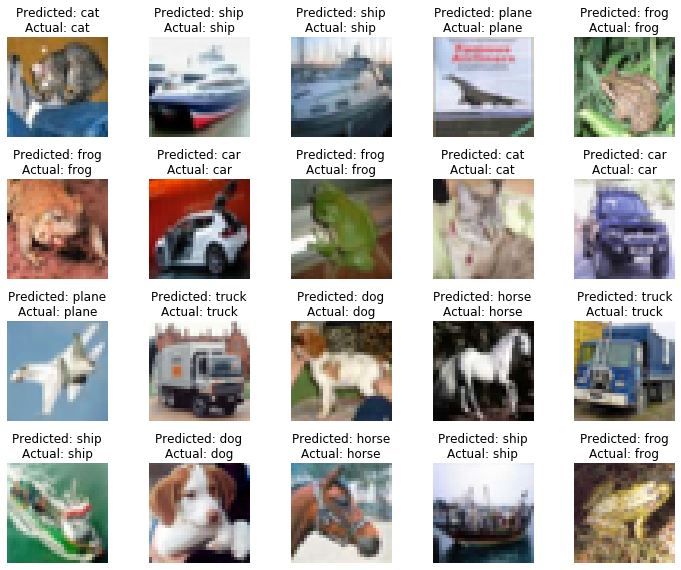

In [22]:
utils.plot_images(correct_images, classes)


### Plot incorrectly predicted images¶


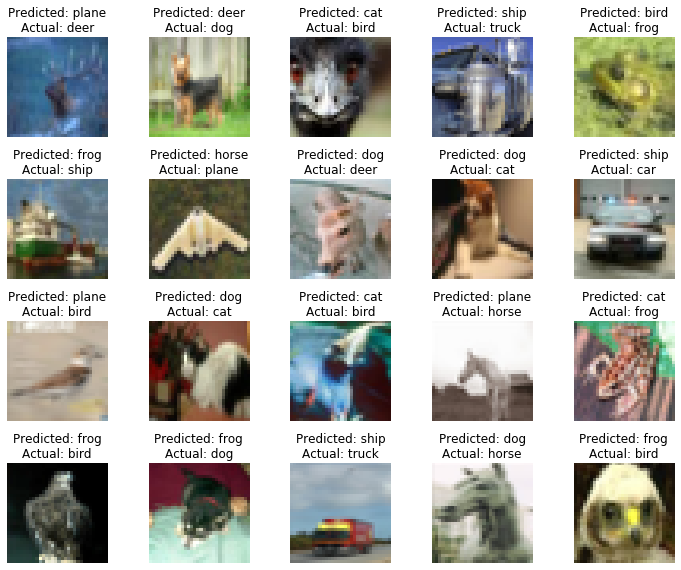

In [23]:
utils.plot_images(incorrect_images, classes)
